AMS 514 Fall 2025 First Project

1. That you understood Gustaffson's analysis of the problem and choice of algorithm. Make any appropriate comments if you agree or disagree. 

Ans. Gustaffson's analysis tries to solve the main challenge with American option pricing, which is the optimal stopping time problem, ie when to exercise the option if exercising gives a higher payoff than continuing to hold the option. The algorithm than Gustaffson uses provides a numerical solution to the problem by using Monte carlo simulations and a regression based functional approximation. Gustaffson shows that the expected discounted payoff can be experessed as a linear combination of a functional transformation of the stock price, specifically the Laguerre polynomial transformation. This approximates the conditional expectation which cannot be computed analytically. Using the value calculated, the algorithm checks if the immediate exercise value exceeds the calculated continuation value and if so, the option is excerised, else the continuation value is furthur discounted backward.

The LSM framework is both conceptually sound and computationally efficient, especially when paired with orthogonal Laguerre polynomials that stabilize the regression and capture the nonlinear relationship between the continuation value and the stock price. The paper’s extension using the Brownian bridge method further improves memory efficiency without sacrificing accuracy, making it a robust implementation of the original LSM idea.

2. Independently implement your own code and compare the results of your code with Gustaffson's. Your own code might result from different choices or the same, but you need to test your code in a meaningful way. 

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from scipy.stats import norm


rng = np.random.default_rng(42)



In [138]:
def simulate_bridge_backward_gbm(S0, r, sigma, T, N, M, rng=rng,q=0.0):
    t = np.linspace(0.0, T, N + 1)
    mu = (r - q) - ((0.5)*sigma**2) # including the dividend in formula
    X = np.zeros((M,N+1))
    M2 = M // 2
    Z_T = rng.standard_normal(M2)

    X[:,-1] = mu*T + sigma*np.sqrt(T)*np.concatenate([Z_T,-Z_T]) # Using antithetic variates for variance reduction
    for j in range(N-1,-1,-1):
        tj, tj1 = t[j], t[j+1]
        if tj==0.0:
            X[:,j]=0.0
            continue
        mean = (tj/tj1)*X[:,j+1]
        var = (sigma**2)*tj*(tj1-tj) / tj1
        Z_t = rng.standard_normal(M2)
        X[:,j]=mean+np.sqrt(var)*np.concatenate([Z_t,-Z_t])
    S = S0*np.exp(X)
    return t,S


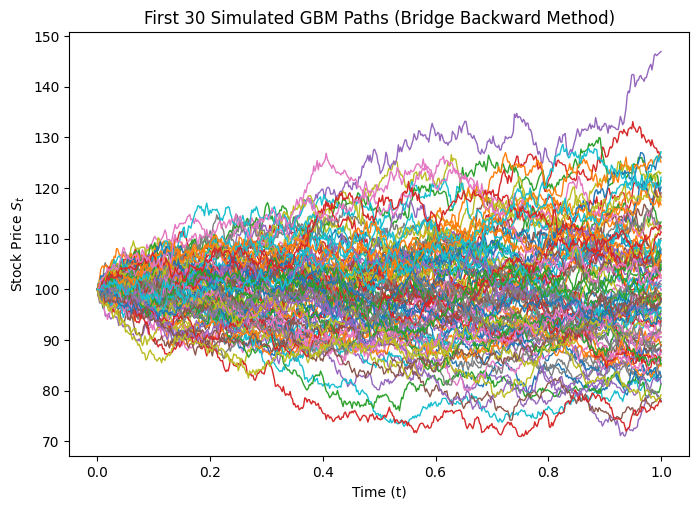

In [113]:
S0, r, sigma, T, N, M = 100, 0.03, 0.15, 1.0, 500, 20000
t_brg, S_brg = simulate_bridge_backward_gbm(S0, r, sigma, T, N, M)

plt.figure(figsize=(8, 5.5))

# Plot the first 30 simulated stock price paths
for i in range(min(100, S_brg.shape[0])):  
    plt.plot(t_brg, S_brg[i, :], lw=1)

plt.xlabel("Time (t)")
plt.ylabel("Stock Price $S_t$")
plt.title("First 30 Simulated GBM Paths (Bridge Backward Method)")
plt.show()



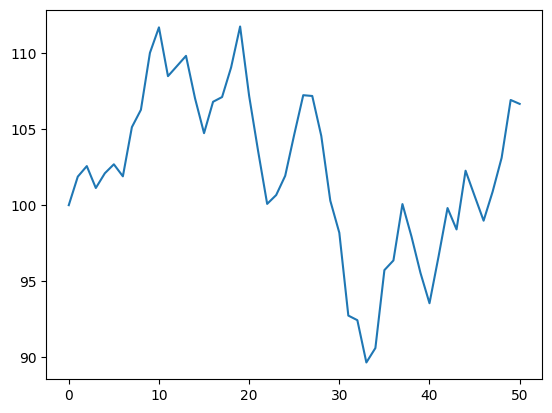

In [ ]:
for i in range(len(S_brg)):

array([[100.        , 101.87571422, 102.56860247, ..., 103.11663793,
        106.91567231, 106.65803137],
       [100.        , 103.41076919, 104.10914807, ...,  90.97822373,
         89.08127146,  87.17543391],
       [100.        , 101.60214277,  99.00677889, ..., 109.91749403,
        110.27131499, 114.03299831],
       ...,
       [100.        ,  98.18327409,  97.72578458, ...,  95.43830035,
         99.24048669, 100.59804965],
       [100.        ,  94.14183554,  93.25791119, ...,  84.96820861,
         85.37521959,  86.07410026],
       [100.        , 100.65734732,  99.32775855, ..., 103.7229105 ,
        102.07925508, 104.7260267 ]])

In [4]:
def laguerre_basis(x, k):
    x = np.asarray(x, dtype=np.float64)
    A = np.ones((len(x), 1))
    if k >= 1:
        A = np.column_stack((A, 1 - x))
    if k >= 2:
        A = np.column_stack((A, 0.5 * (2 - 4*x + x**2)))
    if k >= 3:
        A = np.column_stack((A, (1/6) * (6 - 18*x + 9*x**2 - x**3)))
    if k >= 4:
        A = np.column_stack((A, (1/24) * (24 - 96*x + 72*x**2 - 16*x**3 + x**4)))
    if k >= 5:
        A = np.column_stack((A, (1/120) * (120 - 600*x + 600*x**2 - 200*x**3 + 25*x**4 - x**5)))
    return A

In [139]:
def LSM(T, r, sigma, K, S0, N, M, k, seed=None):
    rng = np.random.default_rng(seed)
    dt = T/N

    t, S =  simulate_bridge_backward_gbm(S0, r, sigma, T, N, M, rng)

    # Calculating the terminal payoff

    P = np.maximum(K-S[:,-1],0)
    
    for i in range(N-1,0,-1):
        Y = P*np.exp(-r*dt)
        X = S[:,i]
        itm=(K-X)>0

        if np.any(itm): # Checks if any of them are in the money 
            X_itm = X[itm] # Seperates the Stock prices which are in the money
            Y_itm = Y[itm] # Seperates the Disounted pay off which are in the money

            # regressing the continuation value on the basis functions
            A = laguerre_basis(X_itm,k)
            beta,*_ = np.linalg.lstsq(A,Y_itm,rcond=None)
            C = A@beta

            # immediate exercise value
            E = K-X_itm

            exercise = E > C
            idx_ex = np.where(itm)[0][exercise] # These are the indices that are in the money and should excerise at time t
            idx_cont = np.setdiff1d(np.arange(M), idx_ex) # These are the indices that are in the money/ or out of the money, but its better to continue 

            # update payoffs
            P[idx_ex] = E[exercise] # We are setting the payoff to be the immediate exercise value
            P[idx_cont] = P[idx_cont] * np.exp(-r * dt) # For coninuing paths, we discount them by 1 time step
        else:
            # no ITM paths, just discount
            P = P * np.exp(-r * dt)

    # option price
    price = np.mean(P * np.exp(-r * dt))
    return price,t,S



    



In [111]:
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 100
N, M, k = 50, 50000, 5
price,t,S, = LSM(T, r, sigma, K, S0, N, M, k, seed=42)
price

4.814369954705484

In [155]:
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 90
N, M, k = 50, 50000, 5
price,t,S, = LSM(T, r, sigma, K, S0, N, M, k, seed=42)
price

10.730459980924588

In [156]:
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 110
N, M, k = 50, 50000, 5
price,t,S, = LSM(T, r, sigma, K, S0, N, M, k, seed=42)
price

1.8361622831996074

We could also compute the value of the put option using isotonic regression since the continuation value should be non-decreasing in S. 

In [6]:
def LSM_put_isotonic(T, r, sigma, K, S0, N, M, k, seed=None):
    rng = np.random.default_rng(seed)
    dt = T/N

    t, S =  simulate_bridge_backward_gbm(S0, r, sigma, T, N, M, rng)
    P = np.maximum(K-S[:,-1],0)

    for i in range(N-1,0,-1):
        Y = P*np.exp(-r*dt)
        X = S[:,i]
        itm=(K-X)>0

        if np.any(itm):
            X_itm = X[itm]
            Y_itm = Y[itm]

            # regressing the continuation value on the basis functions using isotonic regression
            ir = IsotonicRegression(increasing=False, out_of_bounds="clip") # We put increasing = false since when stock price increases, continuation value should decrease in put option if stock price increases
            ir.fit(X_itm,Y_itm)
            C = ir.predict(X_itm)

            # immediate exercise value
            E = K-X_itm

            exercise = E > C
            idx_ex = np.where(itm)[0][exercise]
            idx_cont = np.setdiff1d(np.arange(M), idx_ex)

            # update payoffs
            P[idx_ex] = E[exercise]
            P[idx_cont] = P[idx_cont] * np.exp(-r * dt)
        else:
            # no ITM paths, just discount
            P = P * np.exp(-r * dt)

    # option price
    price = np.mean(P * np.exp(-r * dt))
    return price,t,S
    

In [157]:
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 100
N, M, k = 50, 50000, 5
price,t,S, = LSM_put_isotonic(T, r, sigma, K, S0, N, M, k, seed=42)
price

4.991623442807727

In [158]:
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 90
N, M, k = 50, 50000, 5
price,t,S, = LSM_put_isotonic(T, r, sigma, K, S0, N, M, k, seed=42)
price

10.998836837527874

In [159]:
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 110
N, M, k = 50, 50000, 5
price,t,S, = LSM_put_isotonic(T, r, sigma, K, S0, N, M, k, seed=42)
price

1.9346683294886202

We can see that the put option value calculated using isotonic regression is identical to the linear regression on the laguerre basis function. Now, lets compare the put option value to a binomial tree calculated put option value

In [7]:
def american_put_binomial(S0, K , r, sigma, T, N, q=0.0):
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d=1.0/u

    disc = np.exp(-r*dt)
    m = np.exp((r-q)*dt)
    p = (m-d)/(u-d)

    j = np.arange(N + 1)
    S_T = S0 * (u ** j) * (d ** (N - j))

    V = np.maximum(K - S_T, 0.0)

    for i in range(N-1,-1,-1):
        V = disc * (p*V[1:i+2] + (1-p)*V[0:i+1])
        S_ij = S0 * (u**np.arange(i+1)) * (d ** (i-np.arange(i+1)))
        exercise = K - S_ij

        V = np.maximum(V,exercise)
    return float(V[0])


T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 100
N, M, k = 1000, 50000, 5
price = american_put_binomial(S0,K,r,sigma,T,N)
price

4.82001702699576

In [160]:
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 90
N, M, k = 1000, 50000, 5
price = american_put_binomial(S0,K,r,sigma,T,N)
price

10.726466846198733

In [161]:
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 110
N, M, k = 1000, 50000, 5
price = american_put_binomial(S0,K,r,sigma,T,N)
price

1.8277154365239123

3. Gustaffson's figure 2.1 which apprears purely qualitative motivates his implementation details well. And he does test the error and compute confidence levels for his algorithm. But he does not compute a version of figure 2.1 as a result of his code. You should provide a graph of the exercise boundary of the american put as computed by your code as well as valuations and any other informations needed to assess the credibility of your estimate. 

modifying the code to find the boundary 

In [98]:

def LSM_with_boundary(T, r, sigma, K, S0, N, M, k, seed=None):

    """
    Function Parameters:
    T - Option maturity
    r - risk free interest rate
    sigma - volatility
    K - Strike Price
    S0 - Initial price
    N - Number of time steps
    M - Number of simulated paths
    k - Number of laguerre basis functions
    """

    rng = np.random.default_rng(seed)
    dt = T / N
    t, S = simulate_bridge_backward_gbm(S0, r, sigma, T, N, M, rng)
    P = np.maximum(K - S[:, -1], 0)
    boundary = np.full(N + 1, np.nan)

    for i in range(N - 1, 0, -1):
        Y = P * np.exp(-r * dt)
        X = S[:, i]
        itm = (K - X) > 0
        if np.any(itm):
            X_itm = X[itm]
            Y_itm = Y[itm]
            A = laguerre_basis(X_itm, k)
            beta, *_ = np.linalg.lstsq(A, Y_itm, rcond=None)
            C = A @ beta
            E = K - X_itm
            exercise = E > C
            idx_ex = np.where(itm)[0][exercise]
            idx_cont = np.setdiff1d(np.arange(M), idx_ex)
            P[idx_ex] = E[exercise]
            P[idx_cont] = P[idx_cont] * np.exp(-r * dt)

            # find boundary crossing
            grid = np.linspace(X.min()*0.5, X.max()*1.5, 800)
            Cg = laguerre_basis(grid, k) @ beta
            f = (K - grid) - Cg
            sgn = np.sign(f)
            cross = np.where((sgn[:-1] >= 0) & (sgn[1:] < 0))[0]
            if cross.size > 0:
                j0 = cross[-1]
                x0, x1 = grid[j0], grid[j0 + 1]
                y0, y1 = f[j0], f[j0 + 1]
                boundary[i] = x0 - y0 * (x1 - x0) / (y1 - y0)


                

    # monotone boundary
    mask = np.isfinite(boundary)
    if mask.any():
        interp = np.interp(np.arange(N+1), np.arange(N+1)[mask], boundary[mask])
        boundary = np.maximum.accumulate(interp)
        boundary = np.minimum(boundary, K)

    price = np.mean(P * np.exp(-r * dt))
    return price, t, S, boundary




American Put Price ≈ 4.2134


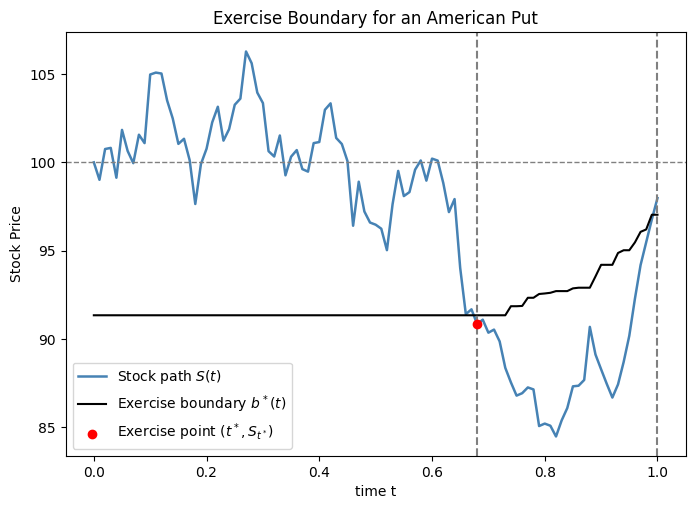

In [114]:
T, r, sigma, K, S0 = 1.0, 0.05, 0.15, 100, 100
N, M, k = 100, 30000, 5

price, t, S, boundary = LSM_with_boundary(T, r, sigma, K, S0, N, M, k, seed=420)
print(f"American Put Price ≈ {price:.4f}")

# pick one path
path_idx = 3
S_path = S[path_idx, :]

# find first time it crosses below boundary
cross = np.where(S_path <= boundary)[0]
if cross.size > 0:
    tau = cross[0]
    t_star, S_star = t[tau], S_path[tau]
else:
    t_star, S_star = np.nan, np.nan

# --- Plot ---
plt.figure(figsize=(8,5.5))
plt.plot(t, S_path, color='steelblue', lw=1.8, label='Stock path $S(t)$')
plt.plot(t, boundary, color='black', lw=1.5, label='Exercise boundary $b^*(t)$')
plt.axhline(K, color='gray', ls='--', lw=1)
if not np.isnan(t_star):
    plt.axvline(t_star, color='gray', ls='--')
    plt.scatter(t_star, S_star, color='red', zorder=5, label='Exercise point $(t^*, S_{t^*})$')
plt.axvline(T, color='gray', ls='--')
plt.xlabel("time t")
plt.ylabel("Stock Price")
plt.title("Exercise Boundary for an American Put")
plt.legend()
plt.show()

Code for no inforced monotonicity

In [85]:

def LSM_with_boundary_testing(T, r, sigma, K, S0, N, M, k, seed=None):

    """
    Function Parameters:
    T - Option maturity
    r - risk free interest rate
    sigma - volatility
    K - Strike Price
    S0 - Initial price
    N - Number of time steps
    M - Number of simulated paths
    k - Number of laguerre basis functions
    """

    rng = np.random.default_rng(seed)
    dt = T / N
    t, S = simulate_bridge_backward_gbm(S0, r, sigma, T, N, M, rng)
    P = np.maximum(K - S[:, -1], 0)
    boundary = np.full(N + 1, np.nan)

    for i in range(N - 1, 0, -1):
        Y = P * np.exp(-r * dt)
        X = S[:, i]
        itm = (K - X) > 0
        if np.any(itm):
            X_itm = X[itm]
            Y_itm = Y[itm]
            A = laguerre_basis(X_itm, k)
            beta, *_ = np.linalg.lstsq(A, Y_itm, rcond=None)
            C = A @ beta
            E = K - X_itm
            exercise = E > C
            idx_ex = np.where(itm)[0][exercise]
            idx_cont = np.setdiff1d(np.arange(M), idx_ex)
            P[idx_ex] = E[exercise]
            P[idx_cont] = P[idx_cont] * np.exp(-r * dt)

            # find boundary crossing
            grid = np.linspace(X.min()*0.5, X.max()*1.5, 800)
            Cg = laguerre_basis(grid, k) @ beta
            f = (K - grid) - Cg
            sgn = np.sign(f)
            cross = np.where((sgn[:-1] >= 0) & (sgn[1:] < 0))[0]
            if cross.size > 0:
                j0 = cross[-1]
                x0, x1 = grid[j0], grid[j0 + 1]
                y0, y1 = f[j0], f[j0 + 1]
                boundary[i] = x0 - y0 * (x1 - x0) / (y1 - y0)

    # monotone boundary
    mask = np.isfinite(boundary)
    if mask.any():
        boundary = np.interp(np.arange(N+1), np.arange(N+1)[mask], boundary[mask])

    price = np.mean(P * np.exp(-r * dt))
    return price, t, S, boundary

American Put Price ≈ 4.2134


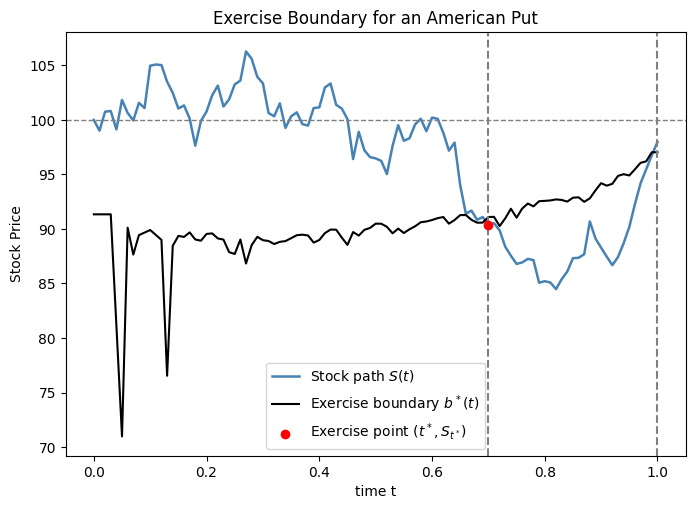

In [115]:
T, r, sigma, K, S0 = 1.0, 0.05, 0.15, 100, 100
N, M, k = 100, 30000, 5

price, t, S, boundary = LSM_with_boundary_testing(T, r, sigma, K, S0, N, M, k, seed=420)
print(f"American Put Price ≈ {price:.4f}")

# pick one path
path_idx = 3
S_path = S[path_idx, :]

# find first time it crosses below boundary
cross = np.where(S_path <= boundary)[0]
if cross.size > 0:
    tau = cross[0]
    t_star, S_star = t[tau], S_path[tau]
else:
    t_star, S_star = np.nan, np.nan

# --- Plot ---
plt.figure(figsize=(8,5.5))
plt.plot(t, S_path, color='steelblue', lw=1.8, label='Stock path $S(t)$')
plt.plot(t, boundary, color='black', lw=1.5, label='Exercise boundary $b^*(t)$')
plt.axhline(K, color='gray', ls='--', lw=1)
if not np.isnan(t_star):
    plt.axvline(t_star, color='gray', ls='--')
    plt.scatter(t_star, S_star, color='red', zorder=5, label='Exercise point $(t^*, S_{t^*})$')
plt.axvline(T, color='gray', ls='--')
plt.xlabel("time t")
plt.ylabel("Stock Price")
plt.title("Exercise Boundary for an American Put")
plt.legend()
plt.show()

Modifying the code to find the boundary in isotonic regression

In [ ]:

def LSM_with_boundary_isotonic(T, r, sigma, K, S0, N, M,seed=None):

    """
    Function Parameters:
    T - Option maturity
    r - risk free interest rate
    sigma - volatility
    K - Strike Price
    S0 - Initial price
    N - Number of time steps
    M - Number of simulated paths
    """

    rng = np.random.default_rng(seed)
    dt = T / N
    t, S = simulate_bridge_backward_gbm(S0, r, sigma, T, N, M, rng)
    P = np.maximum(K - S[:, -1], 0)
    boundary = np.full(N + 1, np.nan)

    for i in range(N - 1, 0, -1):
        Y = P * np.exp(-r * dt)
        X = S[:, i]
        itm = (K - X) > 0
        if np.any(itm):
            X_itm = X[itm]
            Y_itm = Y[itm]


            ir = IsotonicRegression(increasing=False, out_of_bounds="clip")
            ir.fit(X_itm,Y_itm)
            C = ir.predict(X_itm)


            E = K - X_itm
            exercise = E > C
            idx_ex = np.where(itm)[0][exercise]
            idx_cont = np.setdiff1d(np.arange(M), idx_ex)
            P[idx_ex] = E[exercise]
            P[idx_cont] = P[idx_cont] * np.exp(-r * dt)

     
            # --- find boundary crossing ---
            grid = np.linspace(X.min()*0.5, X.max()*1.5, 800)
            Cg = ir.predict(grid)
            f = (K - grid) - Cg
            sgn = np.sign(f)
            cross = np.where((sgn[:-1] >= 0) & (sgn[1:] < 0))[0]
            if cross.size > 0:
                j0 = cross[-1]
                x0, x1 = grid[j0], grid[j0 + 1]
                y0, y1 = f[j0], f[j0 + 1]
                boundary[i] = x0 - y0 * (x1 - x0) / (y1 - y0)
        else:
            P = P * np.exp(-r * dt)

    # --- enforce monotonic boundary (increasing with time) ---
    mask = np.isfinite(boundary)
    if mask.any():
        interp = np.interp(np.arange(N + 1), np.arange(N + 1)[mask], boundary[mask])
        boundary = np.maximum.accumulate(interp)
        boundary = np.minimum(boundary, K)

    price = np.mean(P * np.exp(-r * dt))
    return price, t, S, boundary




American Put Price (Isotonic LSM) ≈ 4.9493


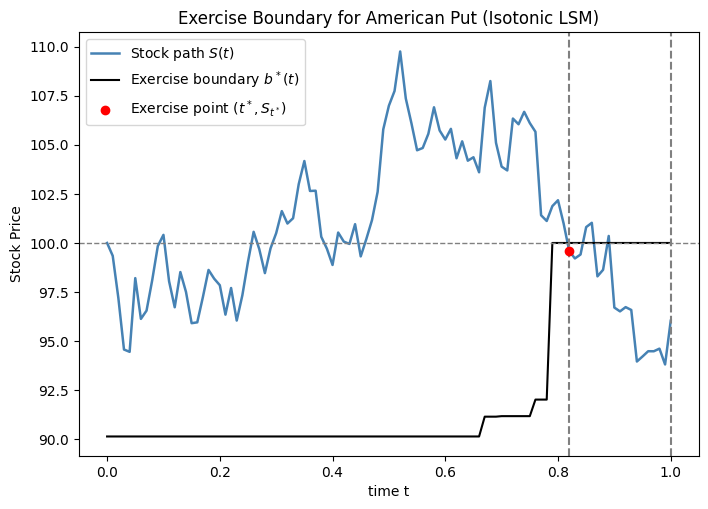

In [116]:
# --- Example usage and plot ---
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 100
N, M = 100, 150000

price, t, S, boundary = LSM_with_boundary_isotonic(T, r, sigma, K, S0, N, M, seed=420)
print(f"American Put Price (Isotonic LSM) ≈ {price:.4f}")

# pick one path
path_idx = 3
S_path = S[path_idx, :]

# find first time it crosses below boundary
cross = np.where(S_path <= boundary)[0]
if cross.size > 0:
    tau = cross[0]
    t_star, S_star = t[tau], S_path[tau]
else:
    t_star, S_star = np.nan, np.nan

# --- Plot ---
plt.figure(figsize=(8, 5.5))
plt.plot(t, S_path, color='steelblue', lw=1.8, label='Stock path $S(t)$')
plt.plot(t, boundary, color='black', lw=1.5, label='Exercise boundary $b^*(t)$')
plt.axhline(K, color='gray', ls='--', lw=1)
if not np.isnan(t_star):
    plt.axvline(t_star, color='gray', ls='--')
    plt.scatter(t_star, S_star, color='red', zorder=5, label='Exercise point $(t^*, S_{t^*})$')
plt.axvline(T, color='gray', ls='--')
plt.xlabel("time t")
plt.ylabel("Stock Price")
plt.title("Exercise Boundary for American Put (Isotonic LSM)")
plt.legend()
plt.show()

In [88]:

def LSM_with_boundary_isotonic_testing(T, r, sigma, K, S0, N, M,seed=None):

    """
    Function Parameters:
    T - Option maturity
    r - risk free interest rate
    sigma - volatility
    K - Strike Price
    S0 - Initial price
    N - Number of time steps
    M - Number of simulated paths
    """

    rng = np.random.default_rng(seed)
    dt = T / N
    t, S = simulate_bridge_backward_gbm(S0, r, sigma, T, N, M, rng)
    P = np.maximum(K - S[:, -1], 0)
    boundary = np.full(N + 1, np.nan)

    for i in range(N - 1, 0, -1):
        Y = P * np.exp(-r * dt)
        X = S[:, i]
        itm = (K - X) > 0
        if np.any(itm):
            X_itm = X[itm]
            Y_itm = Y[itm]


            ir = IsotonicRegression(increasing=False, out_of_bounds="clip")
            ir.fit(X_itm,Y_itm)
            C = ir.predict(X_itm)


            E = K - X_itm
            exercise = E > C
            idx_ex = np.where(itm)[0][exercise]
            idx_cont = np.setdiff1d(np.arange(M), idx_ex)
            P[idx_ex] = E[exercise]
            P[idx_cont] = P[idx_cont] * np.exp(-r * dt)

     
            # --- find boundary crossing ---
            grid = np.linspace(X.min()*0.5, X.max()*1.5, 800)
            Cg = ir.predict(grid)
            f = (K - grid) - Cg
            sgn = np.sign(f)
            cross = np.where((sgn[:-1] >= 0) & (sgn[1:] < 0))[0]
            if cross.size > 0:
                j0 = cross[-1]
                x0, x1 = grid[j0], grid[j0 + 1]
                y0, y1 = f[j0], f[j0 + 1]
                boundary[i] = x0 - y0 * (x1 - x0) / (y1 - y0)
        else:
            P = P * np.exp(-r * dt)

    # --- enforce monotonic boundary (increasing with time) ---
    mask = np.isfinite(boundary)
    if mask.any():
        boundary = np.interp(np.arange(N+1), np.arange(N+1)[mask], boundary[mask])

    price = np.mean(P * np.exp(-r * dt))
    return price, t, S, boundary




American Put Price (Isotonic LSM) ≈ 4.9493


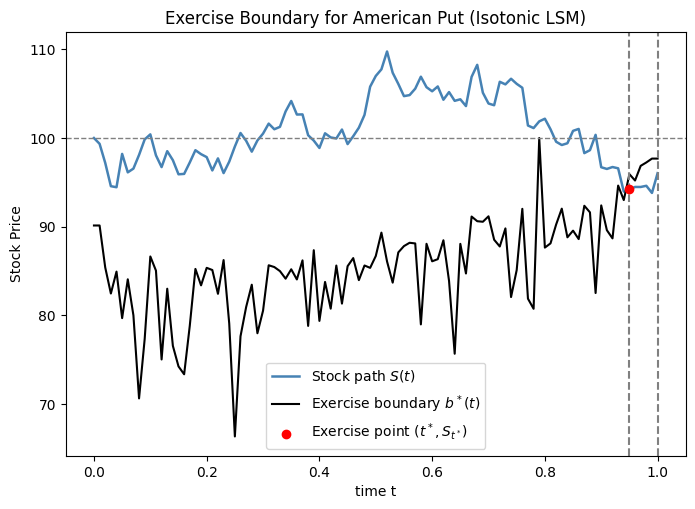

In [117]:
# --- Example usage and plot ---
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 100
N, M = 100, 150000

price, t, S, boundary = LSM_with_boundary_isotonic_testing(T, r, sigma, K, S0, N, M, seed=420)
print(f"American Put Price (Isotonic LSM) ≈ {price:.4f}")

# pick one path
path_idx = 3
S_path = S[path_idx, :]

# find first time it crosses below boundary
cross = np.where(S_path <= boundary)[0]
if cross.size > 0:
    tau = cross[0]
    t_star, S_star = t[tau], S_path[tau]
else:
    t_star, S_star = np.nan, np.nan

# --- Plot ---
plt.figure(figsize=(8, 5.5))
plt.plot(t, S_path, color='steelblue', lw=1.8, label='Stock path $S(t)$')
plt.plot(t, boundary, color='black', lw=1.5, label='Exercise boundary $b^*(t)$')
plt.axhline(K, color='gray', ls='--', lw=1)
if not np.isnan(t_star):
    plt.axvline(t_star, color='gray', ls='--')
    plt.scatter(t_star, S_star, color='red', zorder=5, label='Exercise point $(t^*, S_{t^*})$')
plt.axvline(T, color='gray', ls='--')
plt.xlabel("time t")
plt.ylabel("Stock Price")
plt.title("Exercise Boundary for American Put (Isotonic LSM)")
plt.legend()
plt.show()

Question 4. You should be able to price the American call option and compute the exercise boundary. This is not because anyone is curious about what that exercise boundary is, it is because you want to see how your code performs in computing exercise boundaries. Provide a graph shows the exercise boundary of the American call. If your code uses an iteration, you should show a graph that illustrates the convergence of your algorithm.

In [10]:
def LSM_call(T, r, sigma, K, S0, N, M, k, q, seed=None):
    rng = np.random.default_rng(seed)
    dt = T/N

    t, S =  simulate_bridge_backward_gbm(S0, r, sigma, T, N, M, rng,q)

    # Calculating the terminal payoff

    P = np.maximum(S[:,-1]-K,0)
    
    for i in range(N-1,0,-1):
        Y = P*np.exp(-r*dt)
        X = S[:,i]
        itm=(X-K)>0

        if np.any(itm):
            X_itm = X[itm]
            Y_itm = Y[itm]

            # regressing the continuation value on the basis functions
            A = laguerre_basis(X_itm,k)
            beta,*_ = np.linalg.lstsq(A,Y_itm,rcond=None)
            C = A@beta

            # immediate exercise value
            E = X_itm-K

            exercise = E > C
            idx_ex = np.where(itm)[0][exercise]
            idx_cont = np.setdiff1d(np.arange(M), idx_ex)

            # update payoffs
            P[idx_ex] = E[exercise]
            P[idx_cont] = P[idx_cont] * np.exp(-r * dt)
        else:
            # no ITM paths, just discount
            P = P * np.exp(-r * dt)

    # option price
    price = np.mean(P * np.exp(-r * dt))
    return price,t,S



    



In [14]:
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 100
N, M, k, q = 50, 50000, 5, 0.00
price,t,S = LSM_call(T, r, sigma, K, S0, N, M, k, q, seed=42)
price

7.485720950802415

Now to calculate the call option price using black scholes formula

In [39]:
def black_scholes(S0,K,T,sigma,r,type="call"):
    d1 = (np.log(S0/K)+((r+0.5*(sigma**2)))*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if type=="call":
        price = S0*norm.cdf(d1) - K *np.exp(-r * T)*norm.cdf(d2)
    else:
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)
    
    return(price)


T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 100
price = black_scholes(S0,K,T,sigma,r,"call")
price

7.485087593912603

We can see that the call option value calculated using LSM and with Black Scholes option pricing formula is extremely similar and accurate

In [19]:
def LSM_call_with_boundary(T, r, sigma, K, S0, N, M, k, q, seed=None):

    """
    Function Parameters:
    T - Option maturity
    r - risk free interest rate
    sigma - volatility
    K - Strike Price
    S0 - Initial price
    N - Number of time steps
    M - Number of simulated paths
    k - Number of laguerre basis functions
    q - Dividend rate
    """

    rng = np.random.default_rng(seed)
    dt = T / N
    t, S = simulate_bridge_backward_gbm(S0, r, sigma, T, N, M, rng, q)
    P = np.maximum(S[:, -1] - K , 0)
    boundary = np.full(N + 1, np.nan)

    for i in range(N - 1, 0, -1):
        Y = P * np.exp(-r * dt)
        X = S[:, i]
        itm = (X-K) > 0
        if np.any(itm):
            X_itm = X[itm]
            Y_itm = Y[itm]
            A = laguerre_basis(X_itm, k)
            beta, *_ = np.linalg.lstsq(A, Y_itm, rcond=None)
            C = A @ beta
            E = X_itm - K
            exercise = E > C
            idx_ex = np.where(itm)[0][exercise]
            idx_cont = np.setdiff1d(np.arange(M), idx_ex)
            P[idx_ex] = E[exercise]
            P[idx_cont] = P[idx_cont] * np.exp(-r * dt)

            # find boundary crossing
            grid = np.linspace(X.min()*0.5, X.max()*1.5, 800)

            Cg = laguerre_basis(grid, k) @ beta
            f = (grid-K) - Cg
            sgn = np.sign(f)
            cross = np.where((sgn[:-1] <= 0) & (sgn[1:] > 0))[0]
            if cross.size > 0:
                j0 = cross[0]
                x0, x1 = grid[j0], grid[j0 + 1]
                y0, y1 = f[j0], f[j0 + 1]
                boundary[i] = x0 - y0 * (x1 - x0) / (y1 - y0)

    # monotone boundary
    mask = np.isfinite(boundary)
    if mask.any():
        
        interp = np.interp(np.arange(N+1), np.arange(N+1)[mask], boundary[mask])
        interp = np.maximum(interp, K)                       # boundary ≥ K
        boundary = np.minimum.accumulate(interp[::-1])[::-1]

    price = np.mean(P * np.exp(-r * dt))
    return price, t, S, boundary


American Call Price ≈ 2.7529


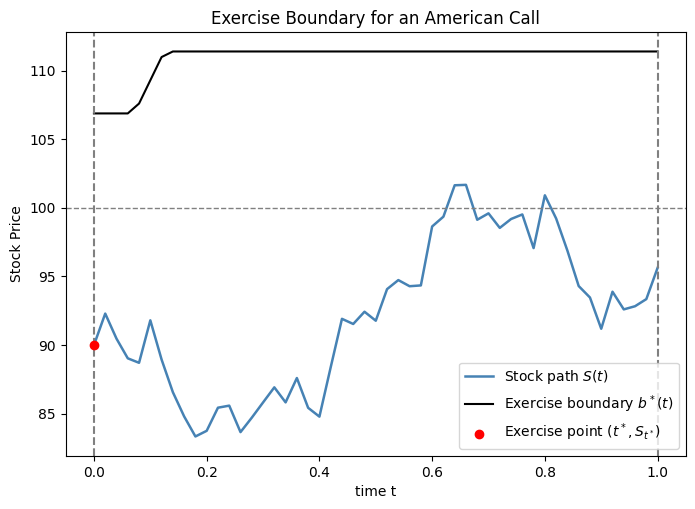

In [75]:
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 90
N, M, k, q = 50, 200000, 5, 0.00

price, t, S, boundary = LSM_call_with_boundary(T, r, sigma, K, S0, N, M, k, q, seed=250)
print(f"American Call Price ≈ {price:.4f}")

# pick one path
path_idx = 4
S_path = S[path_idx, :]

# find first time it crosses below boundary
cross = np.where(S_path <= boundary)[0]
if cross.size > 0:
    tau = cross[0]
    t_star, S_star = t[tau], S_path[tau]
else:
    t_star, S_star = np.nan, np.nan

# --- Plot ---
plt.figure(figsize=(8,5.5))
plt.plot(t, S_path, color='steelblue', lw=1.8, label='Stock path $S(t)$')
plt.plot(t, boundary, color='black', lw=1.5, label='Exercise boundary $b^*(t)$')
plt.axhline(K, color='gray', ls='--', lw=1)
if not np.isnan(t_star):
    plt.axvline(t_star, color='gray', ls='--')
    plt.scatter(t_star, S_star, color='red', zorder=5, label='Exercise point $(t^*, S_{t^*})$')
plt.axvline(T, color='gray', ls='--')
plt.xlabel("time t")
plt.ylabel("Stock Price")
plt.title("Exercise Boundary for an American Call")
plt.legend()
plt.show()

In a perfect market condition, there is no arbitrage condition that implies the option's time value should not be wasted. Therefore, if the option has time (ie, there is still time before expiration), it is mathematically irrational to exercise early because the option's extrinsic value could be higher than the immediate intrinsic value gained by exercising. As we can see, for an american call option without dividends, early exercise is never optimal because the time value is always positive.Hence, the exercise bounds optained does not make sense as compared to the exercise boundary we obtained in the put call chart. Since early exercise is not being done, we can calculate and see that the option price derived from the LSM algorithm is the exact same value as the discounted final payoff value.


In [36]:
def discounting_final_payoff(S0, K, r, sigma, T, M, seed=None):
    rng = np.random.default_rng(seed)
    Z = rng.standard_normal(M)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    final_payoff = np.maximum(ST - K, 0)
    price = np.exp(-r * T) * np.mean(final_payoff)
    return price, ST

S0, K, r, sigma, T, M = 100, 100, 0.03, 0.15, 1.0, 100000

price,_ = discounting_final_payoff(S0, K, r, sigma, T, M)
print(price)

7.534100847924036


In [34]:
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 90
N, M, k, q = 50, 50000, 5, 0.00
price,t,S = LSM_call(T, r, sigma, K, S0, N, M, k, q, seed=42)
price

2.7729429484511896

In [37]:
S0, K, r, sigma, T, M = 90, 100, 0.03, 0.15, 1.0, 100000

price,_ = discounting_final_payoff(S0, K, r, sigma, T, M)
print(price)

2.760994474964454


In [41]:
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 90
price = black_scholes(S0,K,T,sigma,r,"call")
price

2.7584438561460694

In [42]:
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 110
N, M, k, q = 50, 80000, 5, 0.00
price,t,S = LSM_call(T, r, sigma, K, S0, N, M, k, q, seed=42)
price

14.738159141689486

In [43]:
S0, K, r, sigma, T, M = 110, 100, 0.03, 0.15, 1.0, 100000

price,_ = discounting_final_payoff(S0, K, r, sigma, T, M)
print(price)

14.665347730192469


In [44]:
T, r, sigma, K, S0 = 1.0, 0.03, 0.15, 100, 110
price = black_scholes(S0,K,T,sigma,r,"call")
price

14.702019669720784

# Testing for convergence of price of the call/put option

In [144]:
List_M = [5000,10000,20000,40000,80000,100000,120000,150000]

T, r, sigma, K, S0 = 1.0, 0.05, 0.2, 100, 100
N, k, q = 50, 5, 0.00

prices = []
for m in List_M:    
    price,t,S = LSM_call(T, r, sigma, K, S0, N, m, k, q, seed=42)
    prices.append(price)

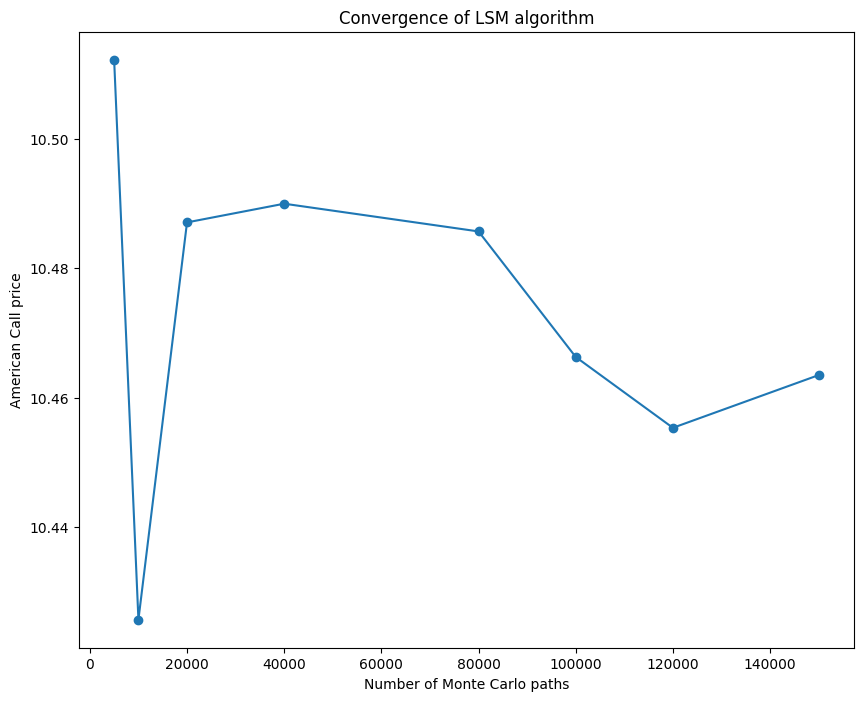

In [145]:
plt.figure(figsize=(10,8))
plt.plot(List_M,prices,marker='o')
plt.xlabel("Number of Monte Carlo paths")
plt.ylabel("American Call price")
plt.title("Convergence of LSM algorithm")
plt.show()

In [61]:
List_M = [5000,10000,20000,40000,80000,100000,120000,150000]
# List_M = list(np.linspace(100000,1000000,10).astype(int))
T, r, sigma, K, S0 = 1.0, 0.05, 0.2, 100, 100
N, k, q = 50, 5, 0.00

prices = []
for m in List_M:    
    price,t,S = LSM(T, r, sigma, K, S0, N, m, k, seed=42)
    prices.append(price)

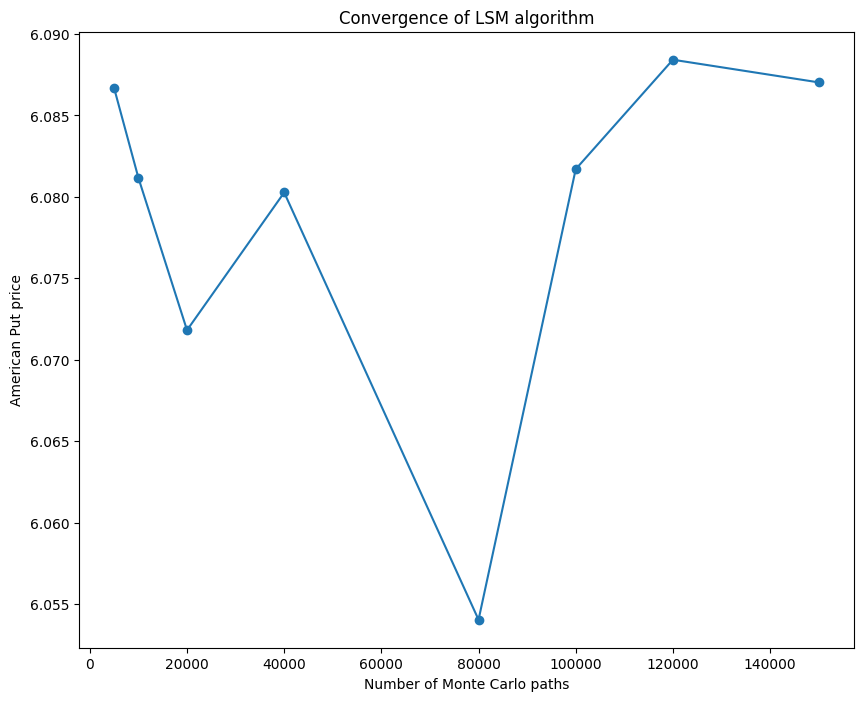

In [62]:
plt.figure(figsize=(10,8))
plt.plot(List_M,prices,marker='o')
plt.xlabel("Number of Monte Carlo paths")
plt.ylabel("American Put price")
plt.title("Convergence of LSM algorithm")
plt.show()

Memory usage Comparison between brownian bridge and standard simulation

In [118]:
import tracemalloc

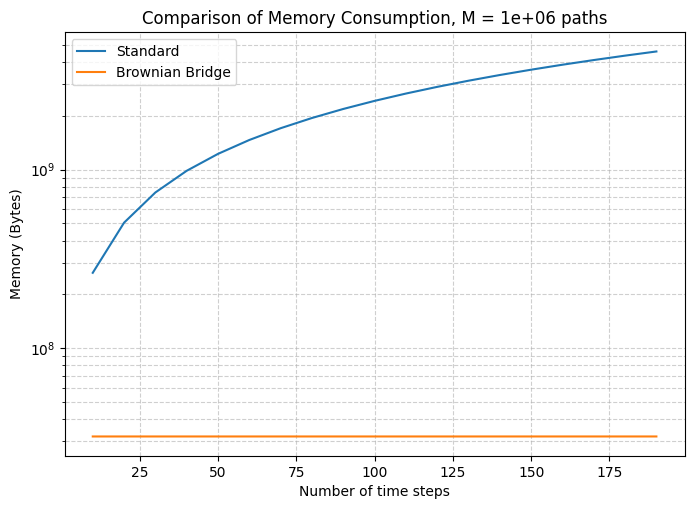

In [123]:
def simulate_standard_gbm_store_all(S0, r, sigma, T, N, M, rng=np.random.default_rng()):
    dt = T / N
    W = np.cumsum(np.sqrt(dt) * rng.standard_normal((M, N)), axis=1)
    W = np.hstack([np.zeros((M, 1)), W])
    S = S0 * np.exp((r - 0.5 * sigma**2) * np.linspace(0, T, N+1) + sigma * W)
    return S  # Stores full matrix

def simulate_bridge_minimal_memory(S0, r, sigma, T, N, M, rng=np.random.default_rng()):
    t = np.linspace(0.0, T, N + 1)
    mu = r - 0.5 * sigma**2
    # Only store the current and next step — constant memory
    X_next = mu*T + sigma*np.sqrt(T)*rng.standard_normal(M)
    for j in range(N-1, -1, -1):
        tj, tj1 = t[j], t[j+1]
        if tj == 0.0:
            break
        mean = (tj/tj1) * X_next
        var = (sigma**2) * tj * (tj1 - tj) / tj1
        X_next = mean + np.sqrt(var) * rng.standard_normal(M)
    S = S0 * np.exp(X_next)  # Only final prices
    return S

def measure_memory(func, *args):
    tracemalloc.start()
    func(*args)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return peak

S0, r, sigma, T = 100, 0.05, 0.2, 1.0
M = 10**6
steps = np.arange(10, 200, 10)

mem_standard = []
mem_bridge = []

for N in steps:
    mem_standard.append(measure_memory(simulate_standard_gbm_store_all, S0, r, sigma, T, N, M))
    mem_bridge.append(measure_memory(simulate_bridge_minimal_memory, S0, r, sigma, T, N, M))

plt.figure(figsize=(8, 5.5))
plt.plot(steps, mem_standard, label="Standard")
plt.plot(steps, mem_bridge, label="Brownian Bridge")
plt.yscale("log")
plt.xlabel("Number of time steps")
plt.ylabel("Memory (Bytes)")
plt.title(f"Comparison of Memory Consumption, M = {M:.0e} paths")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

In [147]:
S0, r, sigma, T, N, M = 100, 0.03, 0.15, 1.0, 500, 20000
S_brg = simulate_bridge_backward_gbm(S0, r, sigma, T, N, M)
S_brg

(array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
        0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
        0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052,
        0.054, 0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 ,
        0.072, 0.074, 0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088,
        0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  , 0.102, 0.104, 0.106,
        0.108, 0.11 , 0.112, 0.114, 0.116, 0.118, 0.12 , 0.122, 0.124,
        0.126, 0.128, 0.13 , 0.132, 0.134, 0.136, 0.138, 0.14 , 0.142,
        0.144, 0.146, 0.148, 0.15 , 0.152, 0.154, 0.156, 0.158, 0.16 ,
        0.162, 0.164, 0.166, 0.168, 0.17 , 0.172, 0.174, 0.176, 0.178,
        0.18 , 0.182, 0.184, 0.186, 0.188, 0.19 , 0.192, 0.194, 0.196,
        0.198, 0.2  , 0.202, 0.204, 0.206, 0.208, 0.21 , 0.212, 0.214,
        0.216, 0.218, 0.22 , 0.222, 0.224, 0.226, 0.228, 0.23 , 0.232,
        0.234, 0.236, 0.238, 0.24 , 0.242, 0.244, 0.246, 0.248, 0.25 ,
      

Relative error calculation

In [136]:
import time

In [143]:
S0,K,r,sigma,T,M = 90,100,0.03,0.15,1,10**5
u_true = 10.726486710094511 # Took the value from Gustafsson's paper
N_values = np.arange(10, 205, 5)
basis_list = [1, 2, 3, 4]

rel_errors = {k: [] for k in basis_list}
exec_times = {k: [] for k in basis_list}

for k in basis_list:
    for N in N_values:
        vals = []
        start = time.time()
        for j in range(20):  # 20 samples
            vals.append(LSM(T, r, sigma, K, S0, N, M, k, seed=j))
        exec_times[k].append(time.time() - start)
        u_hat = np.mean(vals)
        rel_errors[k].append(abs(u_hat - u_true) / u_true)


In [144]:
rel_errors

{1: [0.013260943196224066,
  0.012190121954805287,
  0.011573989356577434,
  0.011493064788935598,
  0.01119629624021432,
  0.011212246228147125,
  0.010892428921407035,
  0.010941507885045937,
  0.0106104412013248,
  0.010615327607665957,
  0.0108839825545896,
  0.01038746638729335,
  0.010610110265052338,
  0.010574127660767188,
  0.010558882317721284,
  0.01068959912309072,
  0.010671280096610959,
  0.010497675185851945,
  0.01057128418363068,
  0.010604360533446995,
  0.010931982697491328,
  0.010788330239472874,
  0.010716594644767579,
  0.010693986852818268,
  0.010504126533118196,
  0.010606835773831735,
  0.01038238409096374,
  0.010344764996658375,
  0.010509802271073048,
  0.010298780872585945,
  0.01036265511694545,
  0.010522718281737427,
  0.010654628513082244,
  0.010639584028347266,
  0.010642897994224524,
  0.010549652482653148,
  0.01053990149150074,
  0.010517045384612,
  0.010584694516238297],
 2: [0.006971501465531688,
  0.005595812924373322,
  0.004710162631729986,

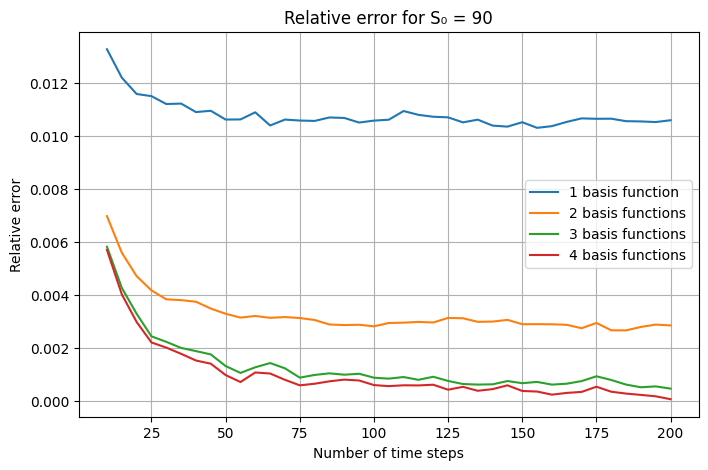

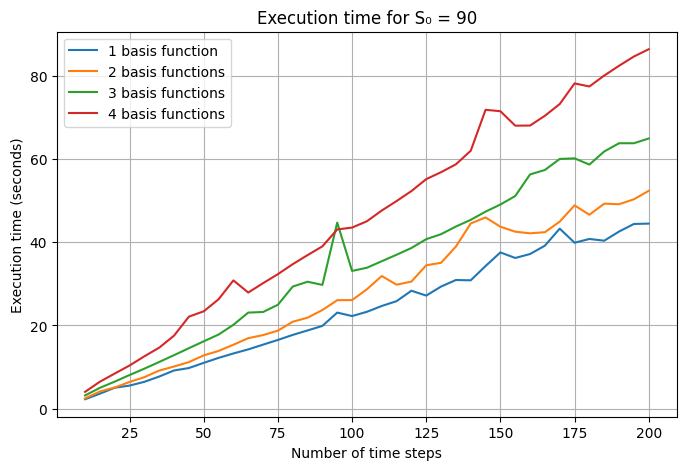

In [145]:
plt.figure(figsize=(8, 5))
for k in basis_list:
    plt.plot(N_values, rel_errors[k], label=f"{k} basis function{'s' if k > 1 else ''}")
plt.xlabel("Number of time steps")
plt.ylabel("Relative error")
plt.title("Relative error for S₀ = 90")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------
# Plot Execution Time
# -------------------------
plt.figure(figsize=(8, 5))
for k in basis_list:
    plt.plot(N_values, exec_times[k], label=f"{k} basis function{'s' if k > 1 else ''}")
plt.xlabel("Number of time steps")
plt.ylabel("Execution time (seconds)")
plt.title("Execution time for S₀ = 90")
plt.legend()
plt.grid(True)
plt.show()

In [142]:
def LSM(T, r, sigma, K, S0, N, M, k, seed=None):
    rng = np.random.default_rng(seed)
    dt = T/N

    t, S =  simulate_bridge_backward_gbm(S0, r, sigma, T, N, M, rng)

    # Calculating the terminal payoff

    P = np.maximum(K-S[:,-1],0)
    
    for i in range(N-1,0,-1):
        Y = P*np.exp(-r*dt)
        X = S[:,i]
        itm=(K-X)>0

        if np.any(itm): # Checks if any of them are in the money 
            X_itm = X[itm] # Seperates the Stock prices which are in the money
            Y_itm = Y[itm] # Seperates the Disounted pay off which are in the money

            # regressing the continuation value on the basis functions
            A = laguerre_basis(X_itm,k)
            beta,*_ = np.linalg.lstsq(A,Y_itm,rcond=None)
            C = A@beta

            # immediate exercise value
            E = K-X_itm

            exercise = E > C
            idx_ex = np.where(itm)[0][exercise] # These are the indices that are in the money and should excerise at time t
            idx_cont = np.setdiff1d(np.arange(M), idx_ex) # These are the indices that are in the money/ or out of the money, but its better to continue 

            # update payoffs
            P[idx_ex] = E[exercise] # We are setting the payoff to be the immediate exercise value
            P[idx_cont] = P[idx_cont] * np.exp(-r * dt) # For coninuing paths, we discount them by 1 time step
        else:
            # no ITM paths, just discount
            P = P * np.exp(-r * dt)

    # option price
    price = np.mean(P * np.exp(-r * dt))
    return price

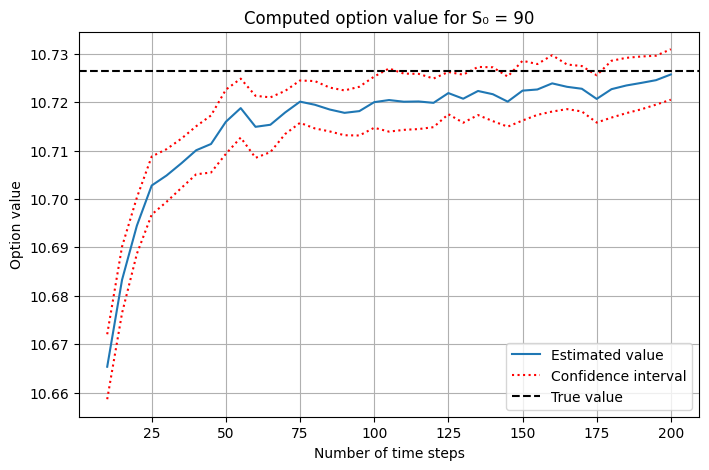

In [146]:
S0 = 90
K = 100
r = 0.03
sigma = 0.15
T = 1
M = 10**5
k = 4        # “most accurate” number of basis functions
u_true = 10.726486710094511

N_values = np.arange(10, 205, 5)
means, lowers, uppers = [], [], []

for N in N_values:
    vals = []
    for j in range(20):  # 20 independent runs
        vals.append(LSM(T, r, sigma, K, S0, N, M, k, seed=j))
    vals = np.array(vals)
    mean = vals.mean()
    std = vals.std(ddof=1)
    ci = 1.96 * std / np.sqrt(len(vals))
    means.append(mean)
    lowers.append(mean - ci)
    uppers.append(mean + ci)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(N_values, means, label="Estimated value")
plt.plot(N_values, lowers, 'r:', label="Confidence interval")
plt.plot(N_values, uppers, 'r:')
plt.axhline(y=u_true, color='k', linestyle='--', label="True value")
plt.xlabel("Number of time steps")
plt.ylabel("Option value")
plt.title("Computed option value for S₀ = 90")
plt.legend()
plt.grid(True)
plt.show()